Classifier for question 7

In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

import re
import math
import string
from collections import Counter
from __future__ import division
from time import time
import logging

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile

import itertools

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

from nltk import FreqDist
from nltk.stem import PorterStemmer
from string import punctuation

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#From scikit's examples
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

class_names = [1, 2, 3, 4, 5]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#read_file is a helper function to get the '|' delimited CSV into a data frame
def read_file(filename):
    #get the file
    df = pd.read_csv(filename, error_bad_lines=False, encoding = 'mbcs')
    
    #Force KIScore to int, otherwise reverts to float. Same for Answer. Forcing NaN to unicode
    df['KIScore'] = df['KIScore'].astype(int)
    df['Answer'] = df['Answer'].astype(str)
    # Filters if needed later on
    #filtered_data = df["Answer"].notnull()
    #filtered_data = df[df["KIScore"] != 1 & df['Answer'].notnull() & df["KIScore"].notnull()]
    #df_narrative = df[filtered_data]
    return df

#reads in the training data into a panda - Steve 
#(code based on ANLP Notebook Intro to Pandas by Marti Hearst and Andrea Gagliano)
def read_training_data(filename):
    df_narrative = read_file(filename)
    return df_narrative

In [4]:
#breaks the panda into a training set and a dev set - Currently only genereates dev and test data
#Modify the function later to keep some data as test data as well

def get_train_and_dev_sets(full_data, percent_dev):
    #randomize the indices
    random_index = np.random.permutation(full_data.index)
    full_data_shuffled = full_data.ix[random_index, ['WISEID', 'Answer', 'KIScore']]
    full_data_shuffled.reset_index(drop=True, inplace=True)
    
    #break down the counts for the shuffled data
    rows, columns = full_data_shuffled.shape
    train_size = round(rows*(1 - percent_dev))
    dev_size   = round(rows*percent_dev)
    
    #separate the training data from the development data
    train_data = full_data_shuffled.loc[:train_size]
    dev_data = full_data_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)

    return train_data, dev_data 

In [5]:
#reads in the test file into a panda
def read_test_data(filename):
    #get the file
    df = read_file(filename)
    return df

df = read_training_data("Tomato.csv")
train_set, dev_set = get_train_and_dev_sets(df,.2)

Norvig's spell checker

In [6]:
TEXT = open('big.txt').read()

def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower())

def tokens_target(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    words = re.findall('[a-z]+', text.lower())
    tagged_POS_sents = nltk.pos_tag(words) # tags sents
    #normed_tagged_words = [wnl.lemmatize(word[0].lower()) for sent in tagged_POS_sents
                           #for word in sent 
                           #if word[0].lower() not in nltk.corpus.stopwords.words('english')
                           #and word[0] not in punctuation # remove punctuation
                           #and not re.search(r'''^[\.,;"'?!():\-_`]+$''', word[0])
                           #and word[1].startswith('N')]  # include only nouns
    #print(tagged_POS_sents)
    return words
    if (len(tagged_POS_sents) > 1):
        normed_tagged_words = [word[0].lower() for word in tagged_POS_sents
                              if (word[1].startswith('N') or word[1].startswith('J') or word[1].startswith('V'))]
        return normed_tagged_words
    else:
        return words

WORDS = tokens(TEXT)

COUNTS = Counter(WORDS)

In [7]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return word
    #return max(candidates, key=COUNTS.get)

# Show what happens in the case of ties
def correct_under_hood (word):
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return candidates

In [8]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [9]:
def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [10]:
spell_checker = lambda x : ' '.join(i for i in list(map(correct, tokens(x))))
normalizer = lambda x : ' '.join(i for i in list(map(correct, tokens_target(x))))
train_set['Answer'] = train_set['Answer'].apply(normalizer)
train_set.head()

,WISEID,Answer,KIScore
0,136565.0,nan,1
1,151214.0,i would cover it when it rains and ill cover i...,2
2,153818.0,the transparency of the structure affects how ...,4
3,150906.0,you have to make it with the most absorbing ma...,3
4,139491.0,the material we use is mostly to be the factor...,4


In [11]:
dev_set['Answer'] = dev_set['Answer'].apply(normalizer)
dev_set.head()

,WISEID,Answer,KIScore
0,139523.0,the important decisions that will impact the t...,4
1,153848.0,i think the structure should be a greenhouse s...,3
2,154153.0,how the sunlight hits and how it will work on ...,3
3,151227.0,the temperature comes from the sun because it ...,3
4,139848.0,nan,1


In [12]:
def transform_dfs_to_arrays(train_set, dev_set):
    vec = CountVectorizer(ngram_range=(1, 4), token_pattern=r'\b\w+\b', stop_words="english", max_features=5000)
    arr_train_feature_sparse = vec.fit_transform(train_set["Answer"].values.astype(str))
    arr_train_feature = arr_train_feature_sparse.toarray()
    
    arr_dev_feature_sparse = vec.transform(dev_set["Answer"].values.astype(str))
    arr_dev_feature = arr_dev_feature_sparse.toarray()
        
    return arr_train_feature, arr_dev_feature

In [13]:
arr_train, arr_dev = transform_dfs_to_arrays(train_set, dev_set)

In [14]:
#From Kaggle

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        #self.snow = SnowballStemmer('english')
    
    #this code will filter punctuation from a word and rejoin it together ("they're" becomes "theyre")
    def __preprocess(self, doc):
       filter_punc = lambda t: ''.join([x.lower() for x in t if x.isalpha()])
       words = [x for x in map(filter_punc, doc.split()) if x]
       review = ""
       for w in words:
           review = review+" "+w
       return review
    
    #Multiple attempts to select lemmas and stems from a word token (using NLTK)
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(self.__preprocess(doc))]

In [15]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1, n_estimators = 100)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=0)
clf6 = SVC(C = 1000000.0, gamma='auto', kernel='rbf', probability = True)
clf8 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf9 = SGDRegressor(shuffle = True, verbose = 0)

eclf_w = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), 
                                    ('clf6', clf6),
                                   ('clf4', clf4), ('clf8', clf8)], 
                                                  weights=[3, 5, 1, 2, 1], voting = 'soft')

eclf_w_predictor = eclf_w.fit(arr_train, train_set.KIScore)
w_predicted = eclf_w_predictor.predict(arr_dev)
accuracy_score(dev_set.KIScore, w_predicted)

0.64846416382252559

In [16]:
print("Accuracy: ",accuracy_score(dev_set.KIScore, w_predicted))
print("Cohen's Kappa: ",cohen_kappa_score(dev_set.KIScore, w_predicted))

Accuracy:  0.648464163823
Cohen's Kappa:  0.469930094495


For this question, we were unable to do the required feature engineering and selection due to time constraints, and therefore this classification relies directly on the classifiers finding the relevant features. This is something we'll be working on during the winter break.

Confusion matrix, without normalization
[[17  0  0  0  0  0]
 [ 5 73 22  0  0  0]
 [ 0 33 84  3  0  0]
 [ 0  6 25 15  0  0]
 [ 0  0  5  3  1  0]
 [ 0  0  0  1  0  0]]


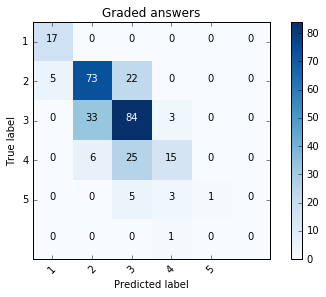

In [17]:
#From scikit's user guide

# Compute confusion matrix
cnf_matrix = confusion_matrix(dev_set.KIScore, w_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Graded answers')